In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision import datasets

In [2]:
# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 2. Custom Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(sorted(os.listdir(img_dir)))}
        self.image_paths = []
        self.labels = []
        for label_name, label_idx in self.label_mapping.items():
            class_folder = os.path.join(img_dir, label_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(img_path)
                        self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# 3. Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
# 4. Load datasets
train_dataset = SkinCancerDataset(img_dir='dataset/train_nohair', transform=transform)
val_dataset = SkinCancerDataset(img_dir='dataset/val_nohair', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Found {len(train_dataset)} training images.")
print(f"Found {len(val_dataset)} validation images.")
print(f"Classes: {train_dataset.label_mapping}")

Found 8012 training images.
Found 2003 validation images.
Classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [6]:
# 5. Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

C:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [8]:
# Replace the final layer
num_classes = len(train_dataset.label_mapping)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [9]:
# 6. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [10]:
# 7. Train the model
num_epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
f1_scores = []

final_train_acc = 0
final_val_acc = 0
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_acc = (running_corrects.double() / total_train) * 100

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            total_val += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / total_val
    val_acc = (val_corrects.double() / total_val) * 100
    f1 = f1_score(all_labels, all_preds, average='macro')

    final_train_acc = train_acc
    final_val_acc = val_acc

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f"F1 Score: {f1:.4f}")

Epoch [1/30] Train Loss: 0.8716, Train Acc: 70.17%, Val Loss: 0.7345, Val Acc: 74.39%, F1 Score: 0.4007
Epoch [2/30] Train Loss: 0.6966, Train Acc: 74.66%, Val Loss: 0.6522, Val Acc: 76.49%, F1 Score: 0.4323
Epoch [3/30] Train Loss: 0.6585, Train Acc: 75.96%, Val Loss: 0.6688, Val Acc: 75.34%, F1 Score: 0.5085
Epoch [4/30] Train Loss: 0.6213, Train Acc: 77.03%, Val Loss: 0.6445, Val Acc: 77.08%, F1 Score: 0.4833
Epoch [5/30] Train Loss: 0.6086, Train Acc: 77.46%, Val Loss: 0.6533, Val Acc: 76.93%, F1 Score: 0.5164
Epoch [6/30] Train Loss: 0.6014, Train Acc: 77.65%, Val Loss: 0.6241, Val Acc: 77.63%, F1 Score: 0.5502
Epoch [7/30] Train Loss: 0.5777, Train Acc: 78.47%, Val Loss: 0.6361, Val Acc: 77.18%, F1 Score: 0.5122
Epoch [8/30] Train Loss: 0.5748, Train Acc: 78.81%, Val Loss: 0.6350, Val Acc: 76.59%, F1 Score: 0.4688
Epoch [9/30] Train Loss: 0.5710, Train Acc: 79.09%, Val Loss: 0.6667, Val Acc: 76.14%, F1 Score: 0.5501
Epoch [10/30] Train Loss: 0.5645, Train Acc: 79.19%, Val Loss: 0

In [12]:
# 9. Save the model
torch.save(model.state_dict(), 'resnet50_skin_cancer_nohair.pth')
print("Model saved as resnet50_skin_cancer_nohair.pth"

SyntaxError: incomplete input (4019551152.py, line 3)

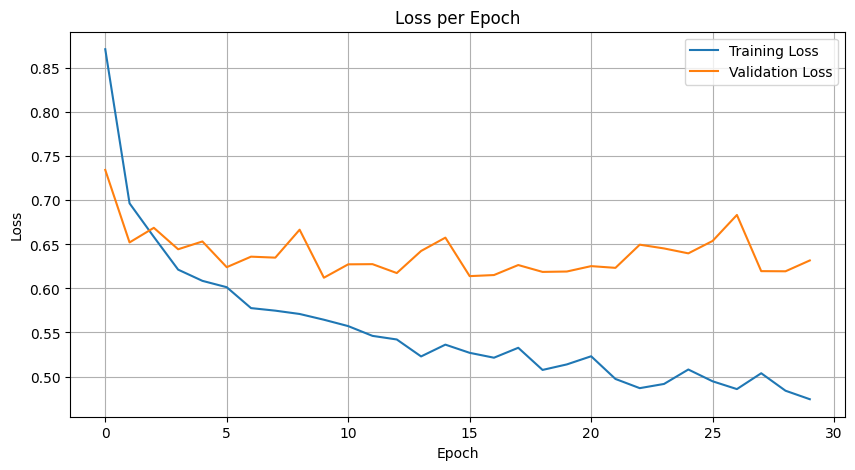

In [13]:
# 10. Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

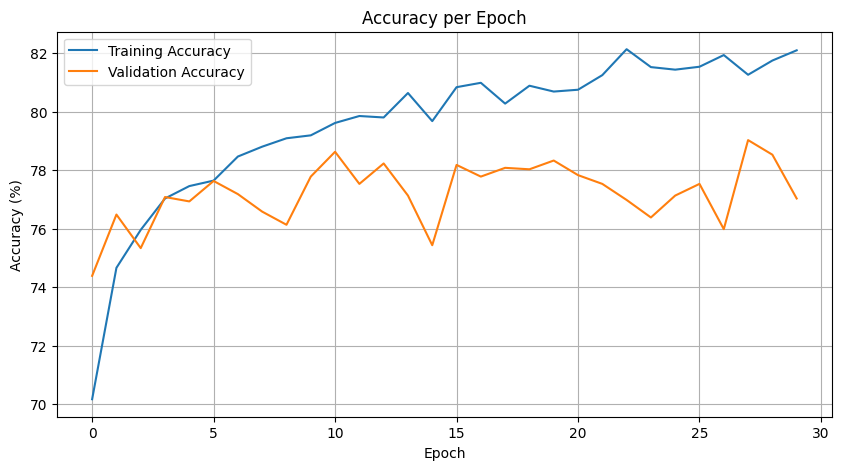

In [14]:
# 11. Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

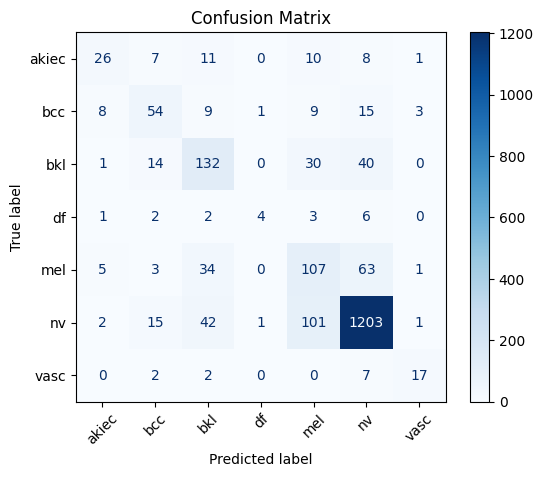

In [15]:
# 12. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(train_dataset.label_mapping.keys()))
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [16]:
# 8. Final overall accuracy after all epochs
print("\nTraining complete!")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


Training complete!
Final Training Accuracy: 82.10%
Final Validation Accuracy: 77.03%
